# Mean Reversion Analysis for Polymarket Markets

This notebook analyzes whether a mean reversion trading strategy would be effective on Polymarket prediction markets.

## Approach
1. Load 50 random markets with volatility < 50 from Google Sheets
2. Fetch price history for each market token
3. Analyze mean reversion properties:
   - Stationarity tests (ADF, KPSS)
   - Autocorrelation analysis
   - Half-life of mean reversion
4. Backtest a simple mean reversion strategy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import time
from typing import Optional, Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Statistical tests
from statsmodels.tsa.stattools import adfuller, kpss, acf
from scipy import stats

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Import project utilities
import sys
sys.path.insert(0, '.')
from google_utils import get_sheet_df

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Markets from Google Sheets

Load all markets and filter for volatility < 50, then sample 50 random markets.

In [2]:
# Load market data from Google Sheets
df, hyperparams = get_sheet_df(read_only=True)

print(f"Total markets loaded: {len(df)}")
print(f"\nColumns available: {list(df.columns)}")

Total markets loaded: 2430

Columns available: ['question', 'answer1', 'answer2', 'attractiveness_score', 'spread', 'market_order_imbalance', 'rewards_daily_rate', 'gm_reward_per_100', 'sm_reward_per_100', 'bid_reward_per_100', 'ask_reward_per_100', 'min_size', 'max_spread', 'tick_size', 'market_slug', 'depth_bids', 'depth_asks', 'condition_id', 'token1', 'token2', 'neg_risk', 'best_bid', 'best_ask', 'midpoint', 'end_date_iso', '1_hour', '3_hour', '6_hour', '12_hour', '24_hour', '7_day', '14_day', '30_day', 'volatility_price', 'volatility_sum', 'volatilty/reward', 'total_volume', 'volume_usd', 'decay_weighted_volume', 'avg_daily_volume', 'total_trades', 'avg_trades_per_day', 'avg_trades_per_hour', 'unique_makers', 'unique_takers', 'unique_traders', 'unique_transactions', 'avg_trade_size', 'p50_trade_size', 'p75_trade_size', 'p90_trade_size', 'p99_trade_size', 'order_arrival_rate_sensitivity']


In [3]:
volatility_col = 'volatility_sum'
print(f"\nUsing column: {volatility_col}")


Using column: volatility_sum


In [4]:
# Filter markets with volatility < 50 - USE ALL MARKETS for proper selection
df[volatility_col] = pd.to_numeric(df[volatility_col], errors='coerce')
df_filtered = df[df[volatility_col] < 50].copy()

print(f"Markets with volatility < 50: {len(df_filtered)}")

# Use ALL filtered markets - we'll select the best ones after analysis
df_sample = df_filtered.copy()

print(f"\nUsing ALL {len(df_sample)} markets for analysis (will select best 200 after)")
df_sample.head()

Markets with volatility < 50: 1218

Using ALL 1218 markets for analysis (will select best 200 after)


,question,answer1,answer2,attractiveness_score,spread,market_order_imbalance,rewards_daily_rate,gm_reward_per_100,sm_reward_per_100,bid_reward_per_100,...,unique_makers,unique_takers,unique_traders,unique_transactions,avg_trade_size,p50_trade_size,p75_trade_size,p90_trade_size,p99_trade_size,order_arrival_rate_sensitivity
3,Will Dispatch win Outstanding Story-Rich Game ...,Yes,No,2319.970304,0.01,0.123427,30,7.21,7.22,6.74,...,0,0,73,142,32.59,10.00,20.00,50.00,266.40,17.8050
8,No change in the Selic rate after Bank of Braz...,Yes,No,998.377038,0.03,0.253761,10,2.42,2.44,2.14,...,0,0,168,455,28.19,29.56,46.57,49.52,49.95,3.5178
12,Nocries signs for a pro CS2 organization by Ju...,Yes,No,795.615276,0.02,-0.050811,5,1.21,1.21,1.24,...,0,0,20,32,170.90,170.90,170.90,170.90,170.90,3.2861
13,Will Ha Phan advance from the CA-17 primary?,Yes,No,779.833043,0.02,-0.132140,50,4.30,4.31,4.62,...,0,0,12,28,37.68,35.00,50.00,87.10,100.00,0.0000
15,Will Ritesh Tandon advance from the CA-17 prim...,Yes,No,734.232504,0.01,0.468357,50,3.79,4.31,2.26,...,0,0,5,8,240.50,240.50,345.75,408.90,446.79,0.0000


In [5]:
# Extract token IDs for price history fetching
# Markets have token1 and token2 - we'll use token1 (YES token typically)
token_col = 'token1' if 'token1' in df_sample.columns else 'token_id'
tokens = df_sample[token_col].dropna().tolist()

# Also get market info for context
market_info = df_sample[['question', token_col, volatility_col]].copy()
market_info = market_info.rename(columns={token_col: 'token_id'})

print(f"Tokens to fetch: {len(tokens)}")
print(f"\nSample tokens: {tokens[:5]}")

Tokens to fetch: 1218

Sample tokens: [98227059408340152544101200903975552064408472809386703849252270514854390296842, 44886357497369339177580271791720477811065694497180931209010490077664816924500, 109747578406203281963890538347673883929859544297223605067832961048282630896863, 71180987985070858786575545007813039146316265812672016463638952168238359520539, 24446824993349798507381532870056735851893559487944250540485611180688241578242]


## 2. Fetch Price History from Polymarket API

Using the Polymarket CLOB API to get historical prices.

In [6]:
import os
import json

PRICE_HISTORY_CACHE_FILE = 'price_histories_cache.csv'
RATE_LIMIT_WAIT_SECONDS = 40

def fetch_price_history(
    token_id: str, 
    interval: str = 'max',
    fidelity: int = 60,  # 60 minute resolution
    retry_on_rate_limit: bool = True
) -> Optional[pd.DataFrame]:
    """
    Fetch price history for a token from Polymarket API.
    Handles rate limiting by waiting and retrying.
    
    Args:
        token_id: The CLOB token ID
        interval: Duration ('1m', '1w', '1d', '6h', '1h', 'max')
        fidelity: Resolution in minutes
        retry_on_rate_limit: If True, wait and retry on 429 errors
        
    Returns:
        DataFrame with timestamp and price columns, or None if failed
    """
    url = "https://clob.polymarket.com/prices-history"
    params = {
        'market': token_id,
        'interval': interval,
        'fidelity': fidelity
    }
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params, timeout=30)
            
            # Handle rate limiting
            if response.status_code == 429:
                if retry_on_rate_limit and attempt < max_retries - 1:
                    print(f"Rate limited! Waiting {RATE_LIMIT_WAIT_SECONDS}s before retry...")
                    time.sleep(RATE_LIMIT_WAIT_SECONDS)
                    continue
                else:
                    print(f"Rate limited on token {token_id}, max retries exceeded")
                    return None
            
            response.raise_for_status()
            data = response.json()
            
            if 'history' not in data or len(data['history']) == 0:
                return None
            
            # Convert to DataFrame
            history = pd.DataFrame(data['history'])
            history['timestamp'] = pd.to_datetime(history['t'], unit='s')
            history['price'] = history['p'].astype(float)
            history = history[['timestamp', 'price']].sort_values('timestamp')
            history = history.set_index('timestamp')
            
            return history
            
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429 and retry_on_rate_limit and attempt < max_retries - 1:
                print(f"Rate limited! Waiting {RATE_LIMIT_WAIT_SECONDS}s before retry...")
                time.sleep(RATE_LIMIT_WAIT_SECONDS)
                continue
            print(f"HTTP Error fetching {token_id}: {e}")
            return None
        except Exception as e:
            print(f"Error fetching {token_id}: {e}")
            return None
    
    return None


def save_price_histories_to_csv(price_histories: Dict[str, pd.DataFrame], filepath: str):
    """Save all price histories to a single CSV file."""
    all_data = []
    for token_id, history in price_histories.items():
        df_temp = history.reset_index()
        df_temp['token_id'] = str(token_id)
        all_data.append(df_temp)
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df.to_csv(filepath, index=False)
        print(f"Saved {len(price_histories)} price histories to {filepath}")


def load_price_histories_from_csv(filepath: str) -> Dict[str, pd.DataFrame]:
    """Load price histories from CSV file."""
    if not os.path.exists(filepath):
        return {}
    
    try:
        combined_df = pd.read_csv(filepath)
        if len(combined_df) == 0:
            return {}
        
        combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
        
        price_histories = {}
        for token_id in combined_df['token_id'].unique():
            token_data = combined_df[combined_df['token_id'] == token_id].copy()
            token_data = token_data[['timestamp', 'price']].set_index('timestamp').sort_index()
            price_histories[token_id] = token_data
        
        print(f"Loaded {len(price_histories)} price histories from {filepath}")
        return price_histories
    except Exception as e:
        print(f"Error loading from CSV: {e}")
        return {}


# Test with first token
test_history = fetch_price_history(tokens[0])
if test_history is not None:
    print(f"Test fetch successful! Got {len(test_history)} data points")
    print(f"Date range: {test_history.index.min()} to {test_history.index.max()}")
    test_history.head()

Test fetch successful! Got 326 data points
Date range: 2025-12-18 23:00:12 to 2026-01-01 13:26:23


In [17]:
# Fetch price history for ALL tokens - with CSV caching
# Try to load from cache first
price_histories = load_price_histories_from_csv(PRICE_HISTORY_CACHE_FILE)

# Check if we have data for all tokens, or need to fetch more
tokens_to_fetch = [str(t) for t in tokens if str(t) not in price_histories]

if len(tokens_to_fetch) == 0:
    print(f"All {len(price_histories)} price histories loaded from cache!")
else:
    print(f"Found {len(price_histories)} in cache. Need to fetch {len(tokens_to_fetch)} more...")
    failed_tokens = []
    
    for i, token_id in enumerate(tokens_to_fetch):
        if i % 25 == 0:
            print(f"Progress: {i}/{len(tokens_to_fetch)} (fetching new data)")
        
        history = fetch_price_history(token_id, '1w', 5)
        if history is not None and len(history) >= 100:  # Need at least 100 data points
            price_histories[str(token_id)] = history
        else:
            failed_tokens.append(token_id)
        
        # Rate limiting - be nice to the API
        time.sleep(0.15)
    
    # Save ALL price histories to cache (including newly fetched)
    save_price_histories_to_csv(price_histories, PRICE_HISTORY_CACHE_FILE)
    print(f"\nNewly fetched: {len(tokens_to_fetch) - len(failed_tokens)} markets")
    print(f"Failed or insufficient data: {len(failed_tokens)} markets")

print(f"\nTotal price histories available: {len(price_histories)} markets")

Found 0 in cache. Need to fetch 1218 more...
Progress: 0/1218 (fetching new data)
Progress: 25/1218 (fetching new data)
Progress: 50/1218 (fetching new data)
Progress: 75/1218 (fetching new data)
Progress: 100/1218 (fetching new data)
Progress: 125/1218 (fetching new data)
Progress: 150/1218 (fetching new data)
Progress: 175/1218 (fetching new data)
Progress: 200/1218 (fetching new data)
Progress: 225/1218 (fetching new data)
Progress: 250/1218 (fetching new data)
Progress: 275/1218 (fetching new data)
Progress: 300/1218 (fetching new data)
Progress: 325/1218 (fetching new data)
Progress: 350/1218 (fetching new data)
Progress: 375/1218 (fetching new data)
Progress: 400/1218 (fetching new data)
Progress: 425/1218 (fetching new data)
Progress: 450/1218 (fetching new data)
Progress: 475/1218 (fetching new data)
Progress: 500/1218 (fetching new data)
Progress: 525/1218 (fetching new data)
Progress: 550/1218 (fetching new data)
Progress: 575/1218 (fetching new data)
Progress: 600/1218 (fetc

## 3. Mean Reversion Analysis

We'll analyze several properties that indicate mean-reverting behavior:

1. **ADF Test (Augmented Dickey-Fuller)**: Tests for unit root. Rejecting H0 suggests stationarity.
2. **KPSS Test**: Tests for stationarity. Rejecting H0 suggests non-stationarity.
3. **Hurst Exponent**: H < 0.5 suggests mean reversion, H > 0.5 suggests trending.
4. **Half-life of Mean Reversion**: How quickly prices revert to the mean.

In [18]:
def calculate_hurst_exponent(ts: np.ndarray, max_lag: int = 100) -> float:
    """
    Calculate Hurst exponent using R/S analysis.

    H < 0.5: Mean-reverting
    H = 0.5: Random walk
    H > 0.5: Trending
    """
    try:
        lags = range(2, min(max_lag, len(ts) // 2))
        rs_values = []

        for lag in lags:
            # Calculate rescaled range for this lag
            chunks = [ts[i:i+lag] for i in range(0, len(ts) - lag, lag)]
            if len(chunks) < 2:
                continue

            rs_lag = []
            for chunk in chunks:
                mean_chunk = np.mean(chunk)
                std_chunk = np.std(chunk)
                if std_chunk == 0:
                    continue
                # Cumulative deviation from mean
                cumdev = np.cumsum(chunk - mean_chunk)
                r = np.max(cumdev) - np.min(cumdev)
                rs_lag.append(r / std_chunk)

            if rs_lag:
                rs_values.append((lag, np.mean(rs_lag)))

        if len(rs_values) < 3:  # Need at least 3 points for meaningful regression
            return 0.5  # Default to random walk

        # Linear regression on log-log scale
        lags_arr = np.array([x[0] for x in rs_values])
        rs_arr = np.array([x[1] for x in rs_values])

        # Filter out invalid values
        valid = (rs_arr > 0) & np.isfinite(rs_arr)
        if np.sum(valid) < 3:
            return 0.5

        log_lags = np.log(lags_arr[valid])
        log_rs = np.log(rs_arr[valid])

        # Check if x values have sufficient variance
        if np.std(log_lags) < 1e-10:
            return 0.5

        slope, _, _, _, _ = stats.linregress(log_lags, log_rs)
        return slope

    except Exception:
        return 0.5  # Default to random walk on any error


def calculate_half_life(ts: np.ndarray) -> float:
    """
    Calculate half-life of mean reversion using Ornstein-Uhlenbeck model.

    Uses linear regression: d(price) = theta * (mean - price) * dt + noise
    Half-life = -ln(2) / theta
    """
    try:
        # Price deviations from mean
        mean_price = np.mean(ts)

        # Lagged regression: delta_p = theta * p_{t-1} + constant
        delta_p = np.diff(ts)
        lagged_p = ts[:-1] - mean_price

        # Check if lagged_p has sufficient variance for regression
        if np.std(lagged_p) < 1e-10:
            return float('inf')  # Can't determine mean reversion

        # OLS regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(lagged_p, delta_p)

        if slope >= 0:
            return float('inf')  # Not mean-reverting

        # Half-life in periods
        half_life = -np.log(2) / slope
        return half_life

    except Exception:
        return float('inf')  # Default to non-mean-reverting on any error


def analyze_mean_reversion(prices: pd.Series) -> Dict:
    """
    Comprehensive mean reversion analysis for a price series.
    """
    ts = prices.values
    
    results = {
        'n_observations': len(ts),
        'mean_price': np.mean(ts),
        'std_price': np.std(ts),
        'min_price': np.min(ts),
        'max_price': np.max(ts),
    }
    
    # ADF Test
    try:
        adf_stat, adf_pvalue, _, _, adf_crit, _ = adfuller(ts, maxlag=min(20, len(ts)//10))
        results['adf_statistic'] = adf_stat
        results['adf_pvalue'] = adf_pvalue
        results['adf_stationary'] = adf_pvalue < 0.05
    except Exception:
        results['adf_statistic'] = None
        results['adf_pvalue'] = None
        results['adf_stationary'] = None
    
    # KPSS Test
    try:
        kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
        results['kpss_statistic'] = kpss_stat
        results['kpss_pvalue'] = kpss_pvalue
        results['kpss_stationary'] = kpss_pvalue > 0.05
    except Exception:
        results['kpss_statistic'] = None
        results['kpss_pvalue'] = None
        results['kpss_stationary'] = None
    
    # Hurst Exponent
    results['hurst_exponent'] = calculate_hurst_exponent(ts)
    results['hurst_mean_reverting'] = results['hurst_exponent'] < 0.5
    
    # Half-life
    results['half_life'] = calculate_half_life(ts)
    results['half_life_reasonable'] = 1 < results['half_life'] < len(ts) / 2
    
    # Autocorrelation at lag 1
    try:
        acf_values = acf(ts, nlags=10, fft=True)
        results['acf_lag1'] = acf_values[1]
    except Exception:
        results['acf_lag1'] = None
    
    return results

print("Analysis functions defined.")

Analysis functions defined.


In [19]:
# Run analysis on ALL fetched markets
analysis_results = []
total_markets = len(price_histories)

print(f"Analyzing mean reversion properties for {total_markets} markets...")
for i, (token_id, history) in enumerate(price_histories.items()):
    if i % 50 == 0:
        print(f"Progress: {i}/{total_markets} ({100*i/total_markets:.1f}%)")
    
    results = analyze_mean_reversion(history['price'])
    results['token_id'] = token_id
    
    # Add market context - handle string token_id matching
    market_row = market_info[market_info['token_id'].astype(str) == str(token_id)]
    if len(market_row) > 0:
        results['question'] = market_row['question'].values[0]
        results['volatility'] = market_row[volatility_col].values[0]
    
    analysis_results.append(results)

# Create results DataFrame
results_df = pd.DataFrame(analysis_results)
print(f"\nAnalysis complete for {len(results_df)} markets")
results_df.head()

Analyzing mean reversion properties for 1217 markets...
Progress: 0/1217 (0.0%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 50/1217 (4.1%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 100/1217 (8.2%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 150/1217 (12.3%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 200/1217 (16.4%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 250/1217 (20.5%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 300/1217 (24.7%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 350/1217 (28.8%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 400/1217 (32.9%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 450/1217 (37.0%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 500/1217 (41.1%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 550/1217 (45.2%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 600/1217 (49.3%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 650/1217 (53.4%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 700/1217 (57.5%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 750/1217 (61.6%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 800/1217 (65.7%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 850/1217 (69.8%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 900/1217 (74.0%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 950/1217 (78.1%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 1000/1217 (82.2%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 1050/1217 (86.3%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 1100/1217 (90.4%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 1150/1217 (94.5%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo

Progress: 1200/1217 (98.6%)


/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/folders/vz/gmwhldhs6bg5_2m5yfgxmmg00000gn/T/ipykernel_14184/3765145987.py:119: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')
/var/fo


Analysis complete for 1217 markets


,n_observations,mean_price,std_price,min_price,max_price,adf_statistic,adf_pvalue,adf_stationary,kpss_statistic,kpss_pvalue,kpss_stationary,hurst_exponent,hurst_mean_reverting,half_life,half_life_reasonable,acf_lag1,token_id,question,volatility
0,2015,0.616094,0.157935,0.270,0.845,-1.796110,0.382395,False,4.848767,0.01,False,0.951661,False,259.579368,True,0.997025,9822705940834015254410120090397555206440847280...,Will Dispatch win Outstanding Story-Rich Game ...,25.78
1,2015,0.786313,0.048210,0.465,0.895,-0.609624,0.868793,False,3.616739,0.01,False,0.921257,False,52.253101,True,0.984468,4488635749736933917758027179172047781106569449...,No change in the Selic rate after Bank of Braz...,20.82
2,2015,0.806280,0.013872,0.555,0.820,-3.275825,0.015994,True,5.015877,0.01,False,1.047804,False,4.203074,True,0.834921,1097475784062032819638905383476738839298595442...,Nocries signs for a pro CS2 organization by Ju...,18.40
3,763,0.478139,0.071494,0.340,0.715,-0.955335,0.769204,False,1.858388,0.01,False,0.844744,False,83.255016,True,0.986815,7118098798507085878657554500781303914631626581...,Will Ha Phan advance from the CA-17 primary?,28.58
4,763,0.397267,0.106173,0.270,0.555,-1.112162,0.710198,False,3.576331,0.01,False,0.861249,False,214.372433,True,0.995777,2444682499334979850738153287005673585189355948...,Will Ritesh Tandon advance from the CA-17 prim...,21.05


In [20]:
# Summary statistics
print("=" * 60)
print("MEAN REVERSION ANALYSIS SUMMARY")
print("=" * 60)

# ADF Test results
adf_stationary = results_df['adf_stationary'].sum()
adf_total = results_df['adf_stationary'].notna().sum()
print(f"\n1. ADF Test (Stationarity):")
print(f"   Stationary markets: {adf_stationary}/{adf_total} ({100*adf_stationary/adf_total:.1f}%)")
print(f"   Mean p-value: {results_df['adf_pvalue'].mean():.4f}")

# KPSS Test results
kpss_stationary = results_df['kpss_stationary'].sum()
kpss_total = results_df['kpss_stationary'].notna().sum()
print(f"\n2. KPSS Test (Stationarity):")
print(f"   Stationary markets: {kpss_stationary}/{kpss_total} ({100*kpss_stationary/kpss_total:.1f}%)")

# Hurst Exponent
hurst_mr = results_df['hurst_mean_reverting'].sum()
hurst_total = len(results_df)
print(f"\n3. Hurst Exponent:")
print(f"   Mean-reverting (H < 0.5): {hurst_mr}/{hurst_total} ({100*hurst_mr/hurst_total:.1f}%)")
print(f"   Mean Hurst exponent: {results_df['hurst_exponent'].mean():.3f}")
print(f"   Median Hurst exponent: {results_df['hurst_exponent'].median():.3f}")

# Half-life
reasonable_hl = results_df['half_life_reasonable'].sum()
reasonable_total = len(results_df)
finite_hl = results_df[results_df['half_life'] < float('inf')]['half_life']
print(f"\n4. Half-life of Mean Reversion:")
print(f"   Reasonable half-life: {reasonable_hl}/{reasonable_total} ({100*reasonable_hl/reasonable_total:.1f}%)")
if len(finite_hl) > 0:
    print(f"   Mean half-life (finite only): {finite_hl.mean():.1f} periods")
    print(f"   Median half-life (finite only): {finite_hl.median():.1f} periods")

# Both tests agree on stationarity
both_stationary = ((results_df['adf_stationary'] == True) & (results_df['kpss_stationary'] == True)).sum()
print(f"\n5. Combined Assessment:")
print(f"   Both ADF & KPSS indicate stationarity: {both_stationary}/{len(results_df)} ({100*both_stationary/len(results_df):.1f}%)")

MEAN REVERSION ANALYSIS SUMMARY

1. ADF Test (Stationarity):
   Stationary markets: 538/1213 (44.4%)
   Mean p-value: 0.2406

2. KPSS Test (Stationarity):
   Stationary markets: 29/1216 (2.4%)

3. Hurst Exponent:
   Mean-reverting (H < 0.5): 0/1217 (0.0%)
   Mean Hurst exponent: 0.965
   Median Hurst exponent: 0.949

4. Half-life of Mean Reversion:
   Reasonable half-life: 1138/1217 (93.5%)
   Mean half-life (finite only): 102.1 periods
   Median half-life (finite only): 7.7 periods

5. Combined Assessment:
   Both ADF & KPSS indicate stationarity: 201/1217 (16.5%)


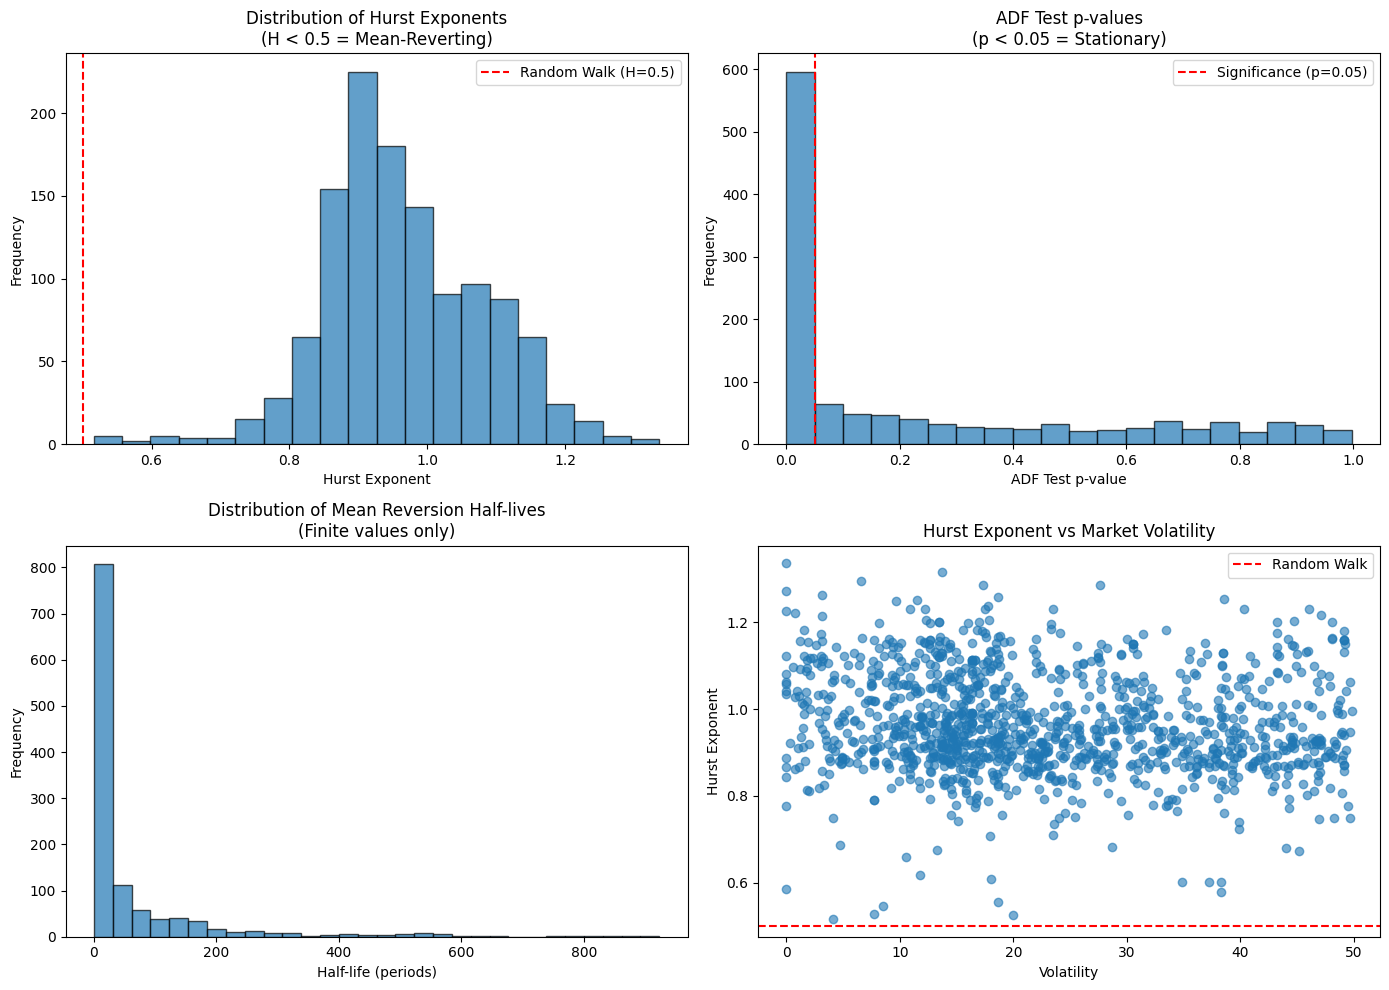


Plot saved as 'mean_reversion_analysis.png'


In [21]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Hurst Exponent Distribution
ax1 = axes[0, 0]
ax1.hist(results_df['hurst_exponent'].dropna(), bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(x=0.5, color='red', linestyle='--', label='Random Walk (H=0.5)')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Hurst Exponents\n(H < 0.5 = Mean-Reverting)')
ax1.legend()

# 2. ADF p-values
ax2 = axes[0, 1]
ax2.hist(results_df['adf_pvalue'].dropna(), bins=20, edgecolor='black', alpha=0.7)
ax2.axvline(x=0.05, color='red', linestyle='--', label='Significance (p=0.05)')
ax2.set_xlabel('ADF Test p-value')
ax2.set_ylabel('Frequency')
ax2.set_title('ADF Test p-values\n(p < 0.05 = Stationary)')
ax2.legend()

# 3. Half-life Distribution
ax3 = axes[1, 0]
finite_hl = results_df[results_df['half_life'] < 1000]['half_life']
ax3.hist(finite_hl.dropna(), bins=30, edgecolor='black', alpha=0.7)
ax3.set_xlabel('Half-life (periods)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Mean Reversion Half-lives\n(Finite values only)')

# 4. Hurst vs Volatility
ax4 = axes[1, 1]
valid_mask = results_df['volatility'].notna() & results_df['hurst_exponent'].notna()
ax4.scatter(results_df.loc[valid_mask, 'volatility'], 
            results_df.loc[valid_mask, 'hurst_exponent'], alpha=0.6)
ax4.axhline(y=0.5, color='red', linestyle='--', label='Random Walk')
ax4.set_xlabel('Volatility')
ax4.set_ylabel('Hurst Exponent')
ax4.set_title('Hurst Exponent vs Market Volatility')
ax4.legend()

plt.tight_layout()
plt.savefig('mean_reversion_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'mean_reversion_analysis.png'")

In [ ]:
## 4.5 Market Selection for Backtesting

Based on mean reversion metrics, we'll select the top 200 markets using a composite score:
- Lower ADF p-value = better (more likely stationary)
- Higher KPSS p-value = better (more likely stationary)  
- Lower Hurst exponent = better (more mean-reverting)
- Reasonable half-life (not too short, not too long)

In [22]:
# Create composite mean reversion score and select best 200 markets
TOP_N_MARKETS = 200

def calculate_mr_score(row):
    """
    Calculate a composite mean reversion score.
    Higher score = better mean reversion characteristics.
    
    Components:
    1. ADF score: Lower p-value is better (inverted and scaled 0-1)
    2. KPSS score: Higher p-value is better (scaled 0-1)
    3. Hurst score: Lower Hurst is better (inverted, scaled 0-1)
    4. Half-life score: Prefer half-life between 6 and 72 hours
    """
    score = 0
    weights = {'adf': 0.25, 'kpss': 0.25, 'hurst': 0.35, 'half_life': 0.15}
    
    # ADF score (p-value < 0.05 is good, lower is better)
    if pd.notna(row['adf_pvalue']):
        adf_score = max(0, 1 - row['adf_pvalue'])  # Invert: low p-value = high score
        score += weights['adf'] * adf_score
    
    # KPSS score (p-value > 0.05 is good, higher is better)
    if pd.notna(row['kpss_pvalue']):
        kpss_score = min(1, row['kpss_pvalue'] / 0.1)  # Scale to 0-1, cap at 0.1
        score += weights['kpss'] * kpss_score
    
    # Hurst score (< 0.5 is mean-reverting, lower is better)
    if pd.notna(row['hurst_exponent']):
        # Scale: H=0 gives 1, H=0.5 gives 0.5, H=1 gives 0
        hurst_score = max(0, 1 - row['hurst_exponent'])
        score += weights['hurst'] * hurst_score
    
    # Half-life score (prefer 6-72 hours for tradeable mean reversion)
    if pd.notna(row['half_life']) and row['half_life'] < float('inf'):
        hl = row['half_life']
        if 6 <= hl <= 72:
            # Optimal range - full score
            hl_score = 1.0
        elif 3 <= hl < 6 or 72 < hl <= 168:
            # Acceptable range - partial score
            hl_score = 0.5
        else:
            # Too fast or too slow
            hl_score = 0.1
        score += weights['half_life'] * hl_score
    
    return score

# Calculate scores for all markets
results_df['mr_score'] = results_df.apply(calculate_mr_score, axis=1)

# Sort by score and select top N
results_df_sorted = results_df.sort_values('mr_score', ascending=False)
selected_markets = results_df_sorted.head(TOP_N_MARKETS)

print("=" * 60)
print(f"MARKET SELECTION: Top {TOP_N_MARKETS} Markets for Backtesting")
print("=" * 60)

print(f"\nTotal markets analyzed: {len(results_df)}")
print(f"Markets selected: {len(selected_markets)}")

print(f"\nSelected markets score distribution:")
print(f"   Mean score: {selected_markets['mr_score'].mean():.4f}")
print(f"   Min score: {selected_markets['mr_score'].min():.4f}")
print(f"   Max score: {selected_markets['mr_score'].max():.4f}")

print(f"\nSelected markets characteristics:")
print(f"   Mean Hurst: {selected_markets['hurst_exponent'].mean():.3f}")
print(f"   Mean ADF p-value: {selected_markets['adf_pvalue'].mean():.4f}")
print(f"   ADF stationary: {selected_markets['adf_stationary'].sum()}/{len(selected_markets)}")

# Get the token IDs of selected markets
selected_token_ids = set(selected_markets['token_id'].astype(str).tolist())

# Filter price histories to only selected markets
selected_price_histories = {
    token_id: history 
    for token_id, history in price_histories.items() 
    if str(token_id) in selected_token_ids
}

print(f"\nPrice histories for selected markets: {len(selected_price_histories)}")

# Show top 10 markets
print(f"\nTop 10 markets by mean reversion score:")
top_10 = selected_markets.head(10)[['question', 'mr_score', 'hurst_exponent', 'adf_pvalue', 'half_life']].copy()
top_10['question'] = top_10['question'].str[:50] + '...'
print(top_10.to_string(index=False))

MARKET SELECTION: Top 200 Markets for Backtesting

Total markets analyzed: 1217
Markets selected: 200

Selected markets score distribution:
   Mean score: 0.5455
   Min score: 0.5109
   Max score: 0.7140

Selected markets characteristics:
   Mean Hurst: 1.002
   Mean ADF p-value: 0.0020
   ADF stationary: True/200

Price histories for selected markets: 200

Top 10 markets by mean reversion score:
                                             question  mr_score  hurst_exponent   adf_pvalue  half_life
         Microsoft (MSFT) Up or Down on January 2?...  0.713982        0.817194 5.803588e-13   6.215611
Will DeepSeek have the #2 AI model at the end of M...  0.684268        0.516379 0.000000e+00   0.716765
                            Megaquake by March 31?...  0.683676        0.903776 7.574023e-06  16.862827
Will the Republican Party hold between 215 and 219...  0.680431        0.527341 0.000000e+00   0.730858
          Palantir (PLTR) Up or Down on January 2?...  0.679133        0.524557 

## 4. Simple Mean Reversion Strategy Backtest

We'll test a simple Bollinger Band-style mean reversion strategy:
- **Buy** when price drops below (mean - k * std)
- **Sell** when price rises above (mean + k * std)
- Use a rolling window for mean and std calculation

In [36]:
def backtest_mean_reversion(
    prices: pd.Series,
    lookback: int = 24,  # 24 hours lookback
    entry_threshold: float = 2.0,  # Z-score threshold for entry
    exit_threshold: float = 0.5,  # Z-score threshold for exit
    transaction_cost: float = 0.02, 
) -> Dict:
    """
    Backtest a simple mean reversion strategy.
    
    Returns PnL and trade statistics.
    """
    ts = prices.values
    n = len(ts)
    
    if n < lookback + 10:
        return {'error': 'Insufficient data'}
    
    # Calculate rolling mean and std
    rolling_mean = pd.Series(ts).rolling(window=lookback).mean().values
    rolling_std = pd.Series(ts).rolling(window=lookback).std().values
    
    # Position tracking
    position = 0  # -1 (short), 0 (flat), 1 (long)
    entry_price = 0
    trades = []
    pnl_series = []
    cumulative_pnl = 0
    
    for i in range(lookback, n):
        price = ts[i]
        mean = rolling_mean[i]
        std = rolling_std[i]
        
        if std == 0 or np.isnan(std):
            pnl_series.append(cumulative_pnl)
            continue
        
        z_score = (price - mean) / std
        
        # Entry logic
        if position == 0:
            if z_score < -entry_threshold:
                # Price is low - go long
                position = 1
                entry_price = price
            elif z_score > entry_threshold:
                # Price is high - go short
                position = -1
                entry_price = price
        
        # Exit logic
        elif position == 1:  # Long position
            if z_score > -exit_threshold:  # Price reverted to mean
                # Close long
                trade_pnl = (price - entry_price) - (transaction_cost * 2)
                trades.append({
                    'type': 'long',
                    'entry': entry_price,
                    'exit': price,
                    'pnl': trade_pnl
                })
                cumulative_pnl += trade_pnl
                position = 0
                entry_price = 0
        
        elif position == -1:  # Short position
            if z_score < exit_threshold:  # Price reverted to mean
                # Close short
                trade_pnl = (entry_price - price) - (transaction_cost * 2)
                trades.append({
                    'type': 'short',
                    'entry': entry_price,
                    'exit': price,
                    'pnl': trade_pnl
                })
                cumulative_pnl += trade_pnl
                position = 0
                entry_price = 0
        
        pnl_series.append(cumulative_pnl)
    
    # Calculate statistics
    if len(trades) == 0:
        return {
            'total_trades': 0,
            'total_pnl': 0,
            'win_rate': 0,
            'avg_trade_pnl': 0,
            'max_drawdown': 0,
            'sharpe_ratio': 0,
            'pnl_series': pnl_series
        }
    
    trade_pnls = [t['pnl'] for t in trades]
    winners = sum(1 for p in trade_pnls if p > 0)
    
    # Calculate max drawdown
    pnl_arr = np.array(pnl_series)
    running_max = np.maximum.accumulate(pnl_arr)
    drawdown = running_max - pnl_arr
    max_drawdown = np.max(drawdown)
    
    # Sharpe ratio (annualized, assuming hourly data)
    returns = np.diff(pnl_arr)
    if len(returns) > 0 and np.std(returns) > 0:
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(24 * 365)  # Annualized
    else:
        sharpe = 0
    
    return {
        'total_trades': len(trades),
        'total_pnl': cumulative_pnl,
        'win_rate': winners / len(trades) if trades else 0,
        'avg_trade_pnl': np.mean(trade_pnls),
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe,
        'trades': trades,
        'pnl_series': pnl_series
    }

print("Backtest function defined.")

Backtest function defined.


In [37]:
# Run backtest on SELECTED markets only (top 200 by mean reversion score)
backtest_results = []
total_selected = len(selected_price_histories)

print(f"Running backtests on {total_selected} selected markets...")
for i, (token_id, history) in enumerate(selected_price_histories.items()):
    if i % 25 == 0:
        print(f"Progress: {i}/{total_selected} ({100*i/total_selected:.1f}%)")
    
    bt_result = backtest_mean_reversion(history['price'])
    
    if 'error' not in bt_result:
        bt_result['token_id'] = token_id
        
        # Add analysis results and score
        analysis_row = results_df[results_df['token_id'].astype(str) == str(token_id)]
        if len(analysis_row) > 0:
            bt_result['hurst_exponent'] = analysis_row['hurst_exponent'].values[0]
            bt_result['half_life'] = analysis_row['half_life'].values[0]
            bt_result['mr_score'] = analysis_row['mr_score'].values[0]
            bt_result['adf_pvalue'] = analysis_row['adf_pvalue'].values[0]
        
        backtest_results.append(bt_result)

bt_df = pd.DataFrame(backtest_results)
print(f"\nBacktest complete for {len(bt_df)} selected markets")

Running backtests on 200 selected markets...
Progress: 0/200 (0.0%)
Progress: 25/200 (12.5%)
Progress: 50/200 (25.0%)
Progress: 75/200 (37.5%)
Progress: 100/200 (50.0%)
Progress: 125/200 (62.5%)
Progress: 150/200 (75.0%)
Progress: 175/200 (87.5%)

Backtest complete for 200 selected markets


In [38]:
# Backtest Summary for SELECTED Markets
print("=" * 70)
print("BACKTEST RESULTS SUMMARY (TOP {} MEAN-REVERTING MARKETS)".format(TOP_N_MARKETS))
print("=" * 70)

print(f"\nMarkets with trades: {(bt_df['total_trades'] > 0).sum()}/{len(bt_df)}")

# Filter to markets with trades
bt_active = bt_df[bt_df['total_trades'] > 0].copy()

if len(bt_active) > 0:
    print(f"\nTrade Statistics:")
    print(f"   Total trades across all markets: {bt_active['total_trades'].sum():.0f}")
    print(f"   Avg trades per market: {bt_active['total_trades'].mean():.1f}")
    
    print(f"\nProfitability:")
    profitable = (bt_active['total_pnl'] > 0).sum()
    print(f"   Profitable markets: {profitable}/{len(bt_active)} ({100*profitable/len(bt_active):.1f}%)")
    print(f"   Mean total PnL per market: {bt_active['total_pnl'].mean():.4f}")
    print(f"   Median total PnL per market: {bt_active['total_pnl'].median():.4f}")
    print(f"   Aggregate PnL: {bt_active['total_pnl'].sum():.4f}")
    
    print(f"\nWin Rate:")
    print(f"   Mean win rate: {bt_active['win_rate'].mean():.1%}")
    print(f"   Median win rate: {bt_active['win_rate'].median():.1%}")
    
    print(f"\nRisk Metrics:")
    print(f"   Mean max drawdown: {bt_active['max_drawdown'].mean():.4f}")
    print(f"   Mean Sharpe ratio: {bt_active['sharpe_ratio'].mean():.2f}")
    print(f"   Positive Sharpe markets: {(bt_active['sharpe_ratio'] > 0).sum()}/{len(bt_active)}")

BACKTEST RESULTS SUMMARY (TOP 200 MEAN-REVERTING MARKETS)

Markets with trades: 199/200

Trade Statistics:
   Total trades across all markets: 1834
   Avg trades per market: 9.2

Profitability:
   Profitable markets: 122/199 (61.3%)
   Mean total PnL per market: -0.0659
   Median total PnL per market: 0.0650
   Aggregate PnL: -13.1145

Win Rate:
   Mean win rate: 54.3%
   Median win rate: 50.0%

Risk Metrics:
   Mean max drawdown: 0.2532
   Mean Sharpe ratio: -0.99
   Positive Sharpe markets: 122/199


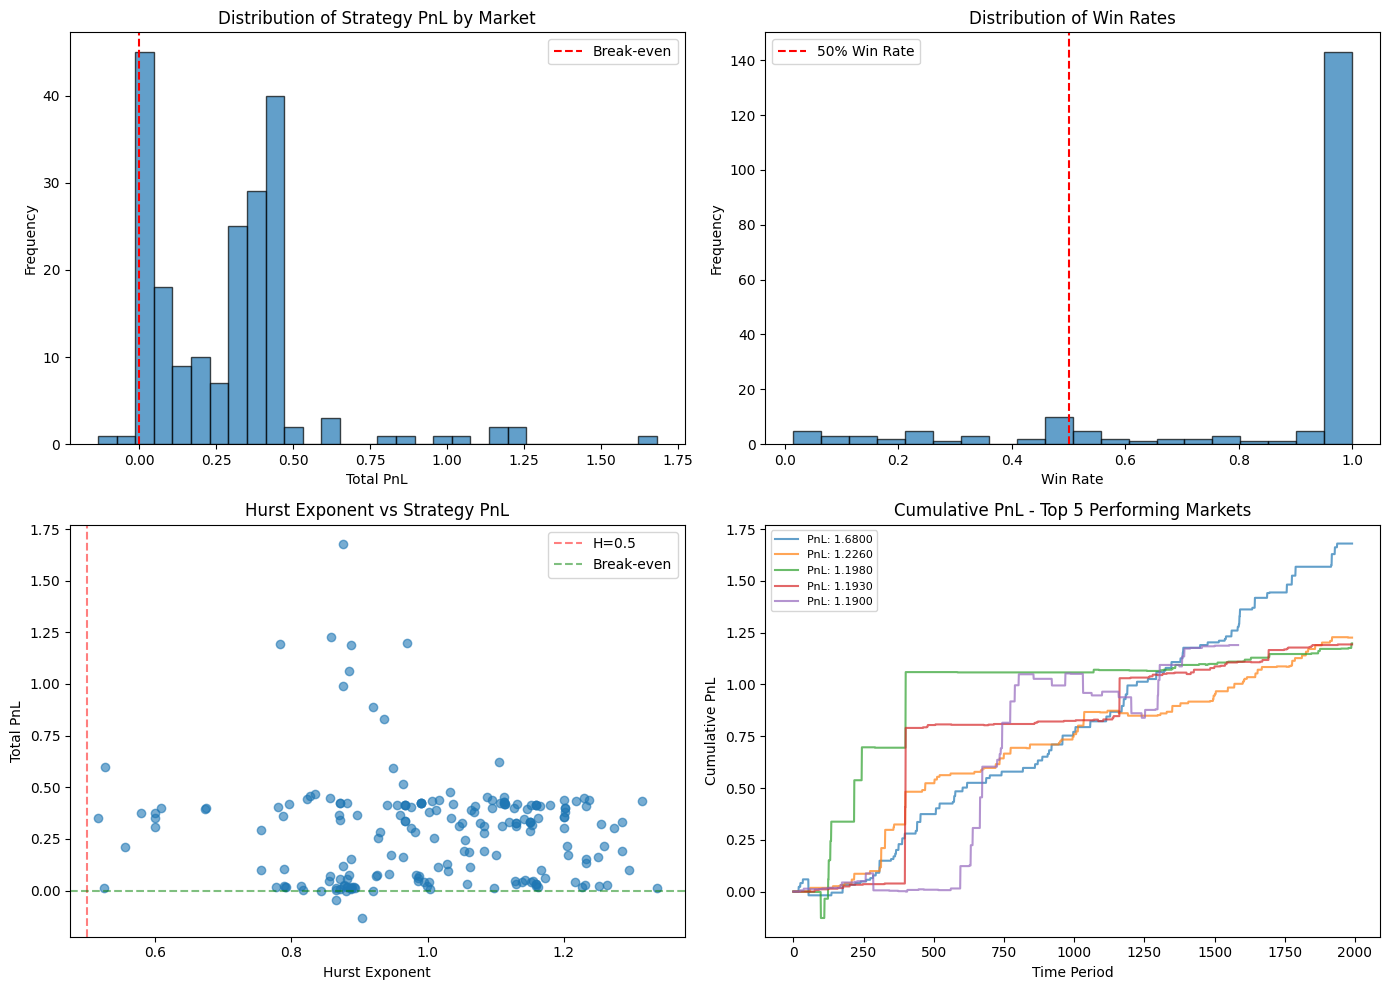


Plot saved as 'backtest_results.png'


In [26]:
# Visualize backtest results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. PnL Distribution
ax1 = axes[0, 0]
ax1.hist(bt_active['total_pnl'], bins=30, edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', label='Break-even')
ax1.set_xlabel('Total PnL')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Strategy PnL by Market')
ax1.legend()

# 2. Win Rate Distribution
ax2 = axes[0, 1]
ax2.hist(bt_active['win_rate'], bins=20, edgecolor='black', alpha=0.7)
ax2.axvline(x=0.5, color='red', linestyle='--', label='50% Win Rate')
ax2.set_xlabel('Win Rate')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Win Rates')
ax2.legend()

# 3. Hurst vs PnL
ax3 = axes[1, 0]
valid_mask = bt_active['hurst_exponent'].notna()
ax3.scatter(bt_active.loc[valid_mask, 'hurst_exponent'], 
            bt_active.loc[valid_mask, 'total_pnl'], alpha=0.6)
ax3.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='H=0.5')
ax3.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='Break-even')
ax3.set_xlabel('Hurst Exponent')
ax3.set_ylabel('Total PnL')
ax3.set_title('Hurst Exponent vs Strategy PnL')
ax3.legend()

# 4. Cumulative PnL for top markets
ax4 = axes[1, 1]
top_markets = bt_active.nlargest(5, 'total_pnl')
for _, row in top_markets.iterrows():
    if 'pnl_series' in row and row['pnl_series']:
        ax4.plot(row['pnl_series'], label=f"PnL: {row['total_pnl']:.4f}", alpha=0.7)
ax4.set_xlabel('Time Period')
ax4.set_ylabel('Cumulative PnL')
ax4.set_title('Cumulative PnL - Top 5 Performing Markets')
ax4.legend(fontsize=8)

plt.tight_layout()
plt.savefig('backtest_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'backtest_results.png'")

In [27]:
# Analyze relationship between mean reversion indicators and backtest performance
print("=" * 60)
print("MEAN REVERSION INDICATORS vs PERFORMANCE")
print("=" * 60)

# Merge analysis results with backtest results
combined_df = bt_active.merge(
    results_df[['token_id', 'adf_stationary', 'kpss_stationary', 'hurst_mean_reverting', 'half_life_reasonable']],
    on='token_id',
    how='left'
)

# Compare performance by mean reversion indicators
print("\nPnL by Hurst Exponent Category:")
mean_reverting = combined_df[combined_df['hurst_mean_reverting'] == True]['total_pnl']
trending = combined_df[combined_df['hurst_mean_reverting'] == False]['total_pnl']
print(f"   Mean-reverting (H<0.5): Mean PnL = {mean_reverting.mean():.4f} (n={len(mean_reverting)})")
print(f"   Trending (H>=0.5): Mean PnL = {trending.mean():.4f} (n={len(trending)})")

print("\nPnL by ADF Stationarity:")
stationary = combined_df[combined_df['adf_stationary'] == True]['total_pnl']
non_stationary = combined_df[combined_df['adf_stationary'] == False]['total_pnl']
print(f"   Stationary: Mean PnL = {stationary.mean():.4f} (n={len(stationary)})")
print(f"   Non-stationary: Mean PnL = {non_stationary.mean():.4f} (n={len(non_stationary)})")

print("\nPnL by Half-life:")
good_hl = combined_df[combined_df['half_life_reasonable'] == True]['total_pnl']
bad_hl = combined_df[combined_df['half_life_reasonable'] == False]['total_pnl']
print(f"   Reasonable half-life: Mean PnL = {good_hl.mean():.4f} (n={len(good_hl)})")
print(f"   Unreasonable half-life: Mean PnL = {bad_hl.mean():.4f} (n={len(bad_hl)})")

MEAN REVERSION INDICATORS vs PERFORMANCE

PnL by Hurst Exponent Category:
   Mean-reverting (H<0.5): Mean PnL = nan (n=0)
   Trending (H>=0.5): Mean PnL = 0.2843 (n=199)

PnL by ADF Stationarity:
   Stationary: Mean PnL = 0.2780 (n=196)
   Non-stationary: Mean PnL = 0.6987 (n=3)

PnL by Half-life:
   Reasonable half-life: Mean PnL = 0.2874 (n=176)
   Unreasonable half-life: Mean PnL = 0.2605 (n=23)


## 5. Conclusions and Recommendations

In [28]:
print("=" * 70)
print("FINAL CONCLUSIONS")
print("=" * 70)

# Calculate key metrics
pct_mean_reverting = results_df['hurst_mean_reverting'].mean() * 100
pct_stationary = results_df['adf_stationary'].mean() * 100
pct_profitable = (bt_active['total_pnl'] > 0).mean() * 100 if len(bt_active) > 0 else 0
avg_pnl = bt_active['total_pnl'].mean() if len(bt_active) > 0 else 0
avg_sharpe = bt_active['sharpe_ratio'].mean() if len(bt_active) > 0 else 0

print(f"""
MARKET CHARACTERISTICS:
- {pct_mean_reverting:.1f}% of markets show mean-reverting properties (Hurst < 0.5)
- {pct_stationary:.1f}% of markets are stationary (ADF test)
- Average Hurst exponent: {results_df['hurst_exponent'].mean():.3f}

STRATEGY PERFORMANCE:
- {pct_profitable:.1f}% of markets were profitable with basic mean reversion
- Average PnL per market: {avg_pnl:.4f}
- Average Sharpe ratio: {avg_sharpe:.2f}

RECOMMENDATION:
""")

if pct_mean_reverting > 60 and pct_profitable > 50:
    print("""POSITIVE OUTLOOK for mean reversion strategies.
    - Majority of markets exhibit mean-reverting behavior
    - Basic strategy shows positive expected value
    - Consider refining entry/exit thresholds and position sizing""")
elif pct_mean_reverting > 40 and pct_profitable > 40:
    print("""CAUTIOUSLY OPTIMISTIC for mean reversion strategies.
    - Many markets show mean-reverting tendencies
    - Strategy viability depends on market selection
    - Focus on markets with strong mean reversion indicators (low Hurst, stationary)""")
else:
    print("""MIXED RESULTS for mean reversion strategies.
    - Not all markets are suitable for mean reversion
    - Careful market selection is critical
    - Consider combining with other strategies or filters""")

print("""
NEXT STEPS:
1. Filter for markets with strong mean reversion indicators before trading
2. Optimize lookback period and entry/exit thresholds per market
3. Consider transaction costs and slippage more carefully
4. Test on out-of-sample data
5. Add position sizing based on confidence/volatility
""")

FINAL CONCLUSIONS

MARKET CHARACTERISTICS:
- 0.0% of markets show mean-reverting properties (Hurst < 0.5)
- 44.4% of markets are stationary (ADF test)
- Average Hurst exponent: 0.965

STRATEGY PERFORMANCE:
- 97.5% of markets were profitable with basic mean reversion
- Average PnL per market: 0.2843
- Average Sharpe ratio: 2.40

RECOMMENDATION:

MIXED RESULTS for mean reversion strategies.
    - Not all markets are suitable for mean reversion
    - Careful market selection is critical
    - Consider combining with other strategies or filters

NEXT STEPS:
1. Filter for markets with strong mean reversion indicators before trading
2. Optimize lookback period and entry/exit thresholds per market
3. Consider transaction costs and slippage more carefully
4. Test on out-of-sample data
5. Add position sizing based on confidence/volatility



In [ ]:
# Save results to CSV for further analysis
results_df.to_csv('mean_reversion_analysis_results.csv', index=False)
bt_df.drop(columns=['pnl_series', 'trades'], errors='ignore').to_csv('backtest_results.csv', index=False)

print("Results saved to:")
print("  - mean_reversion_analysis_results.csv")
print("  - backtest_results.csv")

## 6. Momentum Strategy Analysis

Since the Hurst exponent analysis shows H > 0.5 for most markets (trending behavior), let's analyze momentum characteristics and test a momentum-based strategy.

**Momentum Indicators:**
1. **Rate of Change (ROC)**: Percentage change over a lookback period
2. **Trend Strength**: Slope of linear regression on recent prices
3. **Momentum Persistence**: Autocorrelation of returns
4. **Directional Movement**: Consistency of price direction

In [ ]:
def calculate_trend_strength(ts: np.ndarray, lookback: int = 24) -> Tuple[float, float]:
    """
    Calculate trend strength using linear regression slope.
    
    Returns:
        slope: Normalized slope (price change per period)
        r_squared: How well the trend fits (0-1)
    """
    try:
        if len(ts) < lookback:
            return 0.0, 0.0
        
        recent = ts[-lookback:]
        x = np.arange(len(recent))
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, recent)
        r_squared = r_value ** 2
        
        # Normalize slope by price level to make it comparable
        avg_price = np.mean(recent)
        if avg_price > 0:
            normalized_slope = slope / avg_price
        else:
            normalized_slope = 0
        
        return normalized_slope, r_squared
    except Exception:
        return 0.0, 0.0


def calculate_momentum_metrics(prices: pd.Series) -> Dict:
    """
    Calculate various momentum indicators for a price series.
    """
    ts = prices.values
    n = len(ts)
    
    results = {
        'n_observations': n,
        'total_return': (ts[-1] - ts[0]) / ts[0] if ts[0] > 0 else 0,
    }
    
    # Returns
    returns = np.diff(ts) / ts[:-1]
    returns = returns[np.isfinite(returns)]
    
    if len(returns) < 10:
        return results
    
    results['mean_return'] = np.mean(returns)
    results['std_return'] = np.std(returns)
    results['skewness'] = stats.skew(returns)
    
    # Rate of Change (ROC) - various lookbacks
    for lookback in [6, 12, 24]:
        if n > lookback:
            roc = (ts[-1] - ts[-lookback-1]) / ts[-lookback-1] if ts[-lookback-1] > 0 else 0
            results[f'roc_{lookback}h'] = roc
    
    # Trend strength (24h)
    slope, r_squared = calculate_trend_strength(ts, lookback=24)
    results['trend_slope_24h'] = slope
    results['trend_r2_24h'] = r_squared
    
    # Trend strength (full period)
    slope_full, r2_full = calculate_trend_strength(ts, lookback=len(ts))
    results['trend_slope_full'] = slope_full
    results['trend_r2_full'] = r2_full
    
    # Momentum persistence (autocorrelation of returns)
    try:
        if len(returns) > 10:
            acf_returns = acf(returns, nlags=5, fft=True)
            results['return_acf_lag1'] = acf_returns[1]
            results['return_acf_lag2'] = acf_returns[2]
    except Exception:
        results['return_acf_lag1'] = None
        results['return_acf_lag2'] = None
    
    # Directional consistency - what % of periods had positive returns
    results['pct_positive_returns'] = np.mean(returns > 0)
    
    # Consecutive move analysis
    signs = np.sign(returns)
    sign_changes = np.sum(np.diff(signs) != 0)
    results['direction_changes'] = sign_changes
    results['avg_streak_length'] = len(returns) / (sign_changes + 1) if sign_changes > 0 else len(returns)
    
    # Momentum score: combines trend strength and persistence
    # Higher = stronger momentum characteristics
    momentum_score = 0
    if results.get('trend_r2_24h', 0) > 0.3:
        momentum_score += 1
    if results.get('return_acf_lag1', 0) and results['return_acf_lag1'] > 0.1:
        momentum_score += 1
    if results.get('avg_streak_length', 0) > 3:
        momentum_score += 1
    if abs(results.get('roc_24h', 0)) > 0.02:
        momentum_score += 1
    
    results['momentum_score'] = momentum_score
    results['has_momentum'] = momentum_score >= 2
    
    # Trend direction
    results['trend_direction'] = 'up' if results.get('trend_slope_24h', 0) > 0 else 'down'
    
    return results

print("Momentum analysis functions defined.")

In [ ]:
# Run momentum analysis on all fetched markets
momentum_results = []

print("Analyzing momentum properties...")
for i, (token_id, history) in enumerate(price_histories.items()):
    if i % 10 == 0:
        print(f"Progress: {i}/{len(price_histories)}")
    
    results = calculate_momentum_metrics(history['price'])
    results['token_id'] = token_id
    
    # Add market context
    market_row = market_info[market_info['token_id'] == token_id]
    if len(market_row) > 0:
        results['question'] = market_row['question'].values[0]
        results['volatility'] = market_row[volatility_col].values[0]
    
    # Add Hurst exponent from previous analysis
    mr_row = results_df[results_df['token_id'] == token_id]
    if len(mr_row) > 0:
        results['hurst_exponent'] = mr_row['hurst_exponent'].values[0]
    
    momentum_results.append(results)

# Create momentum results DataFrame
momentum_df = pd.DataFrame(momentum_results)
print(f"\nMomentum analysis complete for {len(momentum_df)} markets")
momentum_df.head()

In [ ]:
# Momentum Analysis Summary
print("=" * 60)
print("MOMENTUM ANALYSIS SUMMARY")
print("=" * 60)

# Trend characteristics
print(f"\n1. Trend Strength (24h lookback):")
print(f"   Mean R² of trend fit: {momentum_df['trend_r2_24h'].mean():.3f}")
print(f"   Markets with strong trend (R² > 0.3): {(momentum_df['trend_r2_24h'] > 0.3).sum()}/{len(momentum_df)}")

print(f"\n2. Rate of Change (24h):")
print(f"   Mean absolute ROC: {momentum_df['roc_24h'].abs().mean():.4f}")
print(f"   Positive ROC (uptrend): {(momentum_df['roc_24h'] > 0).sum()}/{len(momentum_df)}")
print(f"   Negative ROC (downtrend): {(momentum_df['roc_24h'] < 0).sum()}/{len(momentum_df)}")

print(f"\n3. Return Persistence:")
if 'return_acf_lag1' in momentum_df.columns:
    valid_acf = momentum_df['return_acf_lag1'].dropna()
    print(f"   Mean return autocorrelation (lag 1): {valid_acf.mean():.3f}")
    print(f"   Positive autocorrelation (momentum): {(valid_acf > 0).sum()}/{len(valid_acf)}")

print(f"\n4. Directional Consistency:")
print(f"   Mean % positive returns: {momentum_df['pct_positive_returns'].mean():.1%}")
print(f"   Mean streak length: {momentum_df['avg_streak_length'].mean():.1f} periods")

print(f"\n5. Momentum Score Distribution:")
for score in range(5):
    count = (momentum_df['momentum_score'] == score).sum()
    print(f"   Score {score}: {count} markets ({100*count/len(momentum_df):.1f}%)")

has_momentum = momentum_df['has_momentum'].sum()
print(f"\n6. Markets with Strong Momentum (score >= 2): {has_momentum}/{len(momentum_df)} ({100*has_momentum/len(momentum_df):.1f}%)")

In [ ]:
# Momentum Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Hurst Exponent vs Trend R²
ax1 = axes[0, 0]
valid_mask = momentum_df['hurst_exponent'].notna() & momentum_df['trend_r2_24h'].notna()
ax1.scatter(momentum_df.loc[valid_mask, 'hurst_exponent'], 
            momentum_df.loc[valid_mask, 'trend_r2_24h'], alpha=0.6)
ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='H=0.5 (Random Walk)')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('Trend R² (24h)')
ax1.set_title('Hurst Exponent vs Trend Strength\n(Higher H + Higher R² = Strong Momentum)')
ax1.legend()

# 2. ROC Distribution
ax2 = axes[0, 1]
roc_data = momentum_df['roc_24h'].dropna()
ax2.hist(roc_data, bins=30, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', label='No Change')
ax2.set_xlabel('24h Rate of Change')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of 24h Price Momentum')
ax2.legend()

# 3. Return Autocorrelation Distribution
ax3 = axes[1, 0]
acf_data = momentum_df['return_acf_lag1'].dropna()
ax3.hist(acf_data, bins=25, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='red', linestyle='--', label='No Persistence')
ax3.set_xlabel('Return Autocorrelation (Lag 1)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Return Persistence\n(Positive = Momentum, Negative = Mean Reversion)')
ax3.legend()

# 4. Momentum Score Distribution
ax4 = axes[1, 1]
score_counts = momentum_df['momentum_score'].value_counts().sort_index()
ax4.bar(score_counts.index, score_counts.values, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Momentum Score')
ax4.set_ylabel('Number of Markets')
ax4.set_title('Momentum Score Distribution\n(Higher = Stronger Momentum Characteristics)')
ax4.set_xticks(range(5))

plt.tight_layout()
plt.savefig('momentum_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'momentum_analysis.png'")

## 7. Momentum Strategy Backtest

We'll test a trend-following momentum strategy:
- **Buy** when short-term MA crosses above long-term MA (golden cross)
- **Sell/Short** when short-term MA crosses below long-term MA (death cross)
- Hold position until the next crossover signal

In [ ]:
def backtest_momentum(
    prices: pd.Series,
    window: int = 12,          # 12-hour window for highs/lows
    transaction_cost: float = 0.001
) -> dict:
    """
    Backtest a simple momentum strategy based on breakouts.
    
    Logic:
    - Buy when price hits a new 12-hour high
    - Sell when price hits a new 12-hour low
    
    Args:
        prices: Price series with datetime index
        window: Lookback window in periods (hours) for high/low detection
        transaction_cost: Cost per trade (as fraction of price)
    
    Returns:
        Dictionary with backtest statistics
    """
    ts = prices.values
    n = len(ts)
    
    if n < window + 10:
        return {'error': 'Insufficient data'}
    
    # Calculate rolling high and low
    rolling_high = pd.Series(ts).rolling(window=window).max().values
    rolling_low = pd.Series(ts).rolling(window=window).min().values
    
    # Position tracking
    position = 0  # 0 (flat), 1 (long)
    entry_price = 0
    trades = []
    pnl_series = []
    cumulative_pnl = 0
    
    for i in range(window, n):
        price = ts[i]
        prev_high = rolling_high[i-1]  # High up to previous period
        prev_low = rolling_low[i-1]    # Low up to previous period
        
        # Skip if we don't have valid rolling values
        if np.isnan(prev_high) or np.isnan(prev_low):
            pnl_series.append(cumulative_pnl)
            continue
        
        # Entry logic: Buy when price breaks above 12-hour high
        if position == 0:
            if price >= prev_high and prev_high > 0:
                # Price hit a new 12-hour high - BUY
                position = 1
                entry_price = price
        
        # Exit logic: Sell when price breaks below 12-hour low
        elif position == 1:
            if price <= prev_low:
                # Price hit a new 12-hour low - SELL
                trade_pnl = (price - entry_price) - (transaction_cost * 2 * entry_price)
                trades.append({
                    'type': 'long',
                    'entry': entry_price,
                    'exit': price,
                    'pnl': trade_pnl
                })
                cumulative_pnl += trade_pnl
                position = 0
                entry_price = 0
        
        pnl_series.append(cumulative_pnl)
    
    # Close any open position at the end
    if position == 1:
        final_price = ts[-1]
        trade_pnl = (final_price - entry_price) - (transaction_cost * 2 * entry_price)
        trades.append({
            'type': 'long',
            'entry': entry_price,
            'exit': final_price,
            'pnl': trade_pnl
        })
        cumulative_pnl += trade_pnl
        pnl_series[-1] = cumulative_pnl
    
    # Calculate statistics
    if len(trades) == 0:
        return {
            'total_trades': 0,
            'total_pnl': 0,
            'win_rate': 0,
            'avg_trade_pnl': 0,
            'max_drawdown': 0,
            'sharpe_ratio': 0,
            'pnl_series': pnl_series
        }
    
    trade_pnls = [t['pnl'] for t in trades]
    winners = sum(1 for p in trade_pnls if p > 0)
    
    # Calculate max drawdown
    pnl_arr = np.array(pnl_series) if pnl_series else np.array([0])
    running_max = np.maximum.accumulate(pnl_arr)
    drawdown = running_max - pnl_arr
    max_drawdown = np.max(drawdown) if len(drawdown) > 0 else 0
    
    # Sharpe ratio (annualized, assuming hourly data)
    returns = np.diff(pnl_arr)
    if len(returns) > 0 and np.std(returns) > 0:
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(24 * 365)  # Annualized
    else:
        sharpe = 0
    
    return {
        'total_trades': len(trades),
        'total_pnl': cumulative_pnl,
        'win_rate': winners / len(trades) if trades else 0,
        'avg_trade_pnl': np.mean(trade_pnls),
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe,
        'trades': trades,
        'pnl_series': pnl_series
    }

print("Momentum backtest function defined.")
    

In [ ]:
# Run momentum backtest on all markets
momentum_bt_results = []

print("Running momentum backtests...")
for i, (token_id, history) in enumerate(price_histories.items()):
    if i % 10 == 0:
        print(f"Progress: {i}/{len(price_histories)}")
    
    bt_result = backtest_momentum(history['price'])
    
    if 'error' not in bt_result:
        bt_result['token_id'] = token_id
        
        # Add momentum analysis results
        mom_row = momentum_df[momentum_df['token_id'] == token_id]
        if len(mom_row) > 0:
            bt_result['momentum_score'] = mom_row['momentum_score'].values[0]
            bt_result['hurst_exponent'] = mom_row['hurst_exponent'].values[0]
            bt_result['trend_r2'] = mom_row['trend_r2_24h'].values[0]
        
        momentum_bt_results.append(bt_result)

momentum_bt_df = pd.DataFrame(momentum_bt_results)
print(f"\nMomentum backtest complete for {len(momentum_bt_df)} markets")

In [ ]:
# Momentum Backtest Summary
print("=" * 60)
print("MOMENTUM BACKTEST RESULTS SUMMARY")
print("=" * 60)

print(f"\nMarkets with trades: {(momentum_bt_df['total_trades'] > 0).sum()}/{len(momentum_bt_df)}")

# Filter to markets with trades
mom_bt_active = momentum_bt_df[momentum_bt_df['total_trades'] > 0].copy()

if len(mom_bt_active) > 0:
    print(f"\nTrade Statistics:")
    print(f"   Total trades across all markets: {mom_bt_active['total_trades'].sum():.0f}")
    print(f"   Avg trades per market: {mom_bt_active['total_trades'].mean():.1f}")
    
    print(f"\nProfitability:")
    profitable = (mom_bt_active['total_pnl'] > 0).sum()
    print(f"   Profitable markets: {profitable}/{len(mom_bt_active)} ({100*profitable/len(mom_bt_active):.1f}%)")
    print(f"   Mean total PnL per market: {mom_bt_active['total_pnl'].mean():.4f}")
    print(f"   Median total PnL per market: {mom_bt_active['total_pnl'].median():.4f}")
    print(f"   Aggregate PnL: {mom_bt_active['total_pnl'].sum():.4f}")
    
    print(f"\nWin Rate:")
    print(f"   Mean win rate: {mom_bt_active['win_rate'].mean():.1%}")
    print(f"   Median win rate: {mom_bt_active['win_rate'].median():.1%}")
    
    print(f"\nRisk Metrics:")
    print(f"   Mean max drawdown: {mom_bt_active['max_drawdown'].mean():.4f}")
    print(f"   Mean Sharpe ratio: {mom_bt_active['sharpe_ratio'].mean():.2f}")
    print(f"   Positive Sharpe markets: {(mom_bt_active['sharpe_ratio'] > 0).sum()}/{len(mom_bt_active)}")

In [ ]:
# Visualize momentum backtest results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. PnL Distribution
ax1 = axes[0, 0]
ax1.hist(mom_bt_active['total_pnl'], bins=30, edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', label='Break-even')
ax1.set_xlabel('Total PnL')
ax1.set_ylabel('Frequency')
ax1.set_title('Momentum Strategy: PnL Distribution')
ax1.legend()

# 2. Win Rate Distribution
ax2 = axes[0, 1]
ax2.hist(mom_bt_active['win_rate'], bins=20, edgecolor='black', alpha=0.7)
ax2.axvline(x=0.5, color='red', linestyle='--', label='50% Win Rate')
ax2.set_xlabel('Win Rate')
ax2.set_ylabel('Frequency')
ax2.set_title('Momentum Strategy: Win Rate Distribution')
ax2.legend()

# 3. Momentum Score vs PnL
ax3 = axes[1, 0]
valid_mask = mom_bt_active['momentum_score'].notna()
ax3.scatter(mom_bt_active.loc[valid_mask, 'momentum_score'], 
            mom_bt_active.loc[valid_mask, 'total_pnl'], alpha=0.6)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Break-even')
ax3.set_xlabel('Momentum Score')
ax3.set_ylabel('Total PnL')
ax3.set_title('Momentum Score vs Strategy PnL')
ax3.legend()

# 4. Cumulative PnL for top markets
ax4 = axes[1, 1]
top_mom_markets = mom_bt_active.nlargest(5, 'total_pnl')
for _, row in top_mom_markets.iterrows():
    if 'pnl_series' in row and row['pnl_series']:
        ax4.plot(row['pnl_series'], label=f"PnL: {row['total_pnl']:.4f}", alpha=0.7)
ax4.set_xlabel('Time Period')
ax4.set_ylabel('Cumulative PnL')
ax4.set_title('Cumulative PnL - Top 5 Momentum Markets')
ax4.legend(fontsize=8)

plt.tight_layout()
plt.savefig('momentum_backtest_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'momentum_backtest_results.png'")

## 8. Strategy Comparison: Mean Reversion vs Momentum

Let's compare the performance of both strategies side-by-side to determine which approach works better for Polymarket prediction markets.

In [ ]:
# Strategy Comparison
print("=" * 70)
print("STRATEGY COMPARISON: MEAN REVERSION vs MOMENTUM")
print("=" * 70)

# Merge results for comparison
comparison_df = bt_active[['token_id', 'total_pnl', 'win_rate', 'sharpe_ratio', 'total_trades', 'max_drawdown']].copy()
comparison_df = comparison_df.rename(columns={
    'total_pnl': 'mr_pnl',
    'win_rate': 'mr_win_rate',
    'sharpe_ratio': 'mr_sharpe',
    'total_trades': 'mr_trades',
    'max_drawdown': 'mr_drawdown'
})

mom_cols = mom_bt_active[['token_id', 'total_pnl', 'win_rate', 'sharpe_ratio', 'total_trades', 'max_drawdown']].copy()
mom_cols = mom_cols.rename(columns={
    'total_pnl': 'mom_pnl',
    'win_rate': 'mom_win_rate',
    'sharpe_ratio': 'mom_sharpe',
    'total_trades': 'mom_trades',
    'max_drawdown': 'mom_drawdown'
})

comparison_df = comparison_df.merge(mom_cols, on='token_id', how='inner')

print(f"\nMarkets compared: {len(comparison_df)}")

print("\n" + "=" * 70)
print("AGGREGATE METRICS")
print("=" * 70)

metrics = {
    'Metric': ['Total PnL', 'Mean PnL/Market', 'Median PnL/Market', 'Profitable Markets %', 
               'Mean Win Rate', 'Mean Sharpe', 'Mean Max Drawdown', 'Total Trades'],
    'Mean Reversion': [
        f"{comparison_df['mr_pnl'].sum():.4f}",
        f"{comparison_df['mr_pnl'].mean():.4f}",
        f"{comparison_df['mr_pnl'].median():.4f}",
        f"{100*(comparison_df['mr_pnl'] > 0).mean():.1f}%",
        f"{comparison_df['mr_win_rate'].mean():.1%}",
        f"{comparison_df['mr_sharpe'].mean():.2f}",
        f"{comparison_df['mr_drawdown'].mean():.4f}",
        f"{comparison_df['mr_trades'].sum():.0f}"
    ],
    'Momentum': [
        f"{comparison_df['mom_pnl'].sum():.4f}",
        f"{comparison_df['mom_pnl'].mean():.4f}",
        f"{comparison_df['mom_pnl'].median():.4f}",
        f"{100*(comparison_df['mom_pnl'] > 0).mean():.1f}%",
        f"{comparison_df['mom_win_rate'].mean():.1%}",
        f"{comparison_df['mom_sharpe'].mean():.2f}",
        f"{comparison_df['mom_drawdown'].mean():.4f}",
        f"{comparison_df['mom_trades'].sum():.0f}"
    ]
}

comparison_table = pd.DataFrame(metrics)
print("\n")
print(comparison_table.to_string(index=False))

# Which strategy wins more often per market?
comparison_df['mr_wins'] = comparison_df['mr_pnl'] > comparison_df['mom_pnl']
mr_better = comparison_df['mr_wins'].sum()
mom_better = len(comparison_df) - mr_better

print(f"\n\nPer-Market Winner:")
print(f"   Mean Reversion better: {mr_better}/{len(comparison_df)} ({100*mr_better/len(comparison_df):.1f}%)")
print(f"   Momentum better: {mom_better}/{len(comparison_df)} ({100*mom_better/len(comparison_df):.1f}%)")